In [2]:
%pip install PyniteFEA[all]
%pip install Pynite
%pip install trimesh

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


NameError: name 'nodes_df' is not defined

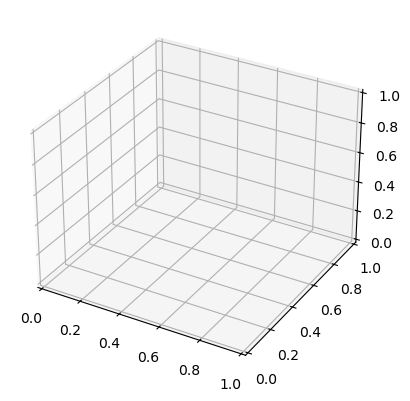

In [3]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Create a new 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all nodes from nodes_df
ax.scatter(nodes_df['X'], nodes_df['Y'], nodes_df['Z'], color='blue', s=20, label='Nodes')

# Plot beams (e.g., red lines)
for idx, row in beams_df.iterrows():
    i_id, j_id = row['i_node'], row['j_node']
    node_i = nodes_df[nodes_df['ID'] == i_id].iloc[0]
    node_j = nodes_df[nodes_df['ID'] == j_id].iloc[0]
    xs = [node_i['X'], node_j['X']]
    ys = [node_i['Y'], node_j['Y']]
    zs = [node_i['Z'], node_j['Z']]
    ax.plot(xs, ys, zs, color='red', linewidth=2, label='Beam' if idx == 0 else "")

# Plot columns (e.g., green lines)
for idx, row in columns_df.iterrows():
    i_id, j_id = row['i_node'], row['j_node']
    node_i = nodes_df[nodes_df['ID'] == i_id].iloc[0]
    node_j = nodes_df[nodes_df['ID'] == j_id].iloc[0]
    xs = [node_i['X'], node_j['X']]
    ys = [node_i['Y'], node_j['Y']]
    zs = [node_i['Z'], node_j['Z']]
    ax.plot(xs, ys, zs, color='green', linewidth=2, label='Column' if idx == 0 else "")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('FE Model: Nodes and Members')
ax.legend()
plt.show()

1. Import Libraries & Initialize the Model

In [4]:
from Pynite.FEModel3D import FEModel3D      # Core FEA class :contentReference[oaicite:0]{index=0}
import pandas as pd                  # For reading CSV input
#from PyNite.Visualization import Renderer  # Optional: for 3D rendering :contentReference[oaicite:1]{index=1}

# Create a new 3D finite element model
model = FEModel3D()


2. Define Material Propertie

In [5]:
# Units: inches & kips
E       = 29_000    # Elastic modulus, ksi
G       = 11_200    # Shear modulus, ksi
nu      = 0.3       # Poisson's ratio (unused internally but for reference)
rho     = 2.836e-4  # Density, kci (kips·in/in³)
Fy      = 36        # Yield strength, ksi (optional)
model.add_material('Steel', E, G, Fy, rho)


'Steel'

3. Define Section Properties

In [6]:
# add_section(name, A, Iy, Iz, J)
# A = area (in²), Iy/Iz = moments of inertia (in⁴), J = torsional constant (in⁴)
model.add_section('W14X30', 8.84, 49.0, 14.4, 0.95)
model.add_section('W12X50', 14.7, 100.0, 30.0, 1.75)


'W12X50'

4. Add Nodes

In [7]:
# nodes.csv must have columns: ID, X, Y, Z
nodes_df = pd.read_csv(r'Documents/nodes.csv')
for _, row in nodes_df.iterrows():
    nid = str(row['ID'])
    x, y, z = row[['X','Y','Z']]
    model.add_node(nid, x, y, z)


5. Add Members (Beams & Columns)

In [8]:
beams_df   = pd.read_csv(r'Documents\beams.csv')
columns_df = pd.read_csv(r'Documents\columns.csv')


# Add beam members (using W14X30)
for _, row in beams_df.iterrows():
    member_id = str(row['ID'])
    if member_id not in model.members:
        model.add_member(member_id,
                         str(row['i_node']),
                         str(row['j_node']),
                         'Steel', 'W14X30')
    else:
        print(f"Member {member_id} already exists. Skipping duplicate addition.")

# Add column members (using W12X50)
for _, row in columns_df.iterrows():
    member_id = str(row['ID'])
    if member_id not in model.members:
        model.add_member(member_id,
                         str(row['i_node']),
                         str(row['j_node']),
                         'Steel', 'W12X50')
    else:
        print(f"Member {member_id} already exists. Skipping duplicate addition.")

6. Define Supports

Explanation:

def_support takes six booleans: (tx, ty, tz, rx, ry, rz).

Here every ground‐level node (Z=0) is fully fixed.

In [9]:
# Fully fix all nodes at Z=0 in all 6 DOFs
for _, row in nodes_df.iterrows():
    if row['Z'] == 0:
        model.def_support(
            row['ID'],   # Node ID
            True, True, True,    # Tx, Ty, Tz fixed
            True, True, True     # Rx, Ry, Rz fixed
        )

    else:
        model.def_support(
            row['ID'],   # Node ID
            0, 0, 0,  # Tx, Ty, Tz free
            0, 0, 0   # Rx, Ry, Rz free
        )


In [10]:
print("\n=== Support Flags for All Nodes ===")
for name, node in model.nodes.items():
    flags = (
        node.support_DX,  node.support_DY,  node.support_DZ,
        node.support_RX,  node.support_RY,  node.support_RZ
    )
    print(f"{name:4s} : DX={flags[0]}, DY={flags[1]}, DZ={flags[2]}, "
          f"RX={flags[3]}, RY={flags[4]}, RZ={flags[5]}")
print("===================================\n")



=== Support Flags for All Nodes ===
N0   : DX=True, DY=True, DZ=True, RX=True, RY=True, RZ=True
N1   : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N2   : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N3   : DX=True, DY=True, DZ=True, RX=True, RY=True, RZ=True
N4   : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N5   : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N6   : DX=True, DY=True, DZ=True, RX=True, RY=True, RZ=True
N7   : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N8   : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N9   : DX=True, DY=True, DZ=True, RX=True, RY=True, RZ=True
N10  : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N11  : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N12  : DX=True, DY=True, DZ=True, RX=True, RY=True, RZ=True
N13  : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N14  : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N15  : DX=True, DY=True, DZ=True, RX=True, RY=True, RZ=True
N16  : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N17  : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ=0
N18  : DX=True, DY=True, DZ=True, RX=True, RY=True, RZ=True
N19  : DX=0, DY=0, DZ=0, RX=0, RY=0, RZ

7. Apply Loads

In [11]:
# Assume you added loads using cases 'DL','LL','SW','EQ'
model.add_load_combo(
    'ALL',                 # a new combo name
    {                      # dictionary of case:factors
        'DL': 1.0,
        'LL': 1.0,
        'SW': 1.0,
        'EQ': 1.0
    }
)

# Now run the analysis against that combo:
model.analyze(combo_tags=['ALL'])


In [12]:
# Create a new load combo for gravity if not already defined
model.add_load_combo('GRAV', {'GRAV': 1.0})

# Apply a uniform gravity load in the Y direction (assumed value: -0.1 kips)
gravity_load = -0.1  # adjust this value as needed

for node_id in model.nodes:
    model.add_node_load(node_id, 'FY', gravity_load, 'GRAV')

In [13]:
# Suppose you’ve already built your model: nodes, members, supports, loads, etc.
model.analyze(
    log=True,              # Print iteration details to console
    check_stability=True,  
    check_statics=False,   
    max_iter=20,           # Allow up to 20 iter for tension/compression-only 
    sparse=True            
)
# After this returns, you can extract node displacements and member forces.


+-----------+
| Analyzing |
+-----------+

- Analyzing load combination ALL
- Adding nodal spring support stiffness terms to global stiffness matrix
- Adding spring stiffness terms to global stiffness matrix
- Adding member stiffness terms to global stiffness matrix
- Adding quadrilateral stiffness terms to global stiffness matrix
- Adding plate stiffness terms to global stiffness matrix
- Checking nodal stability
- Calculating global displacement vector
- Checking for tension/compression-only support spring convergence
- Checking for tension/compression-only spring convergence
- Checking for tension/compression-only member convergence
- Tension/compression-only analysis converged after 1 iteration(s)

- Analyzing load combination GRAV
- Adding nodal spring support stiffness terms to global stiffness matrix
- Adding spring stiffness terms to global stiffness matrix
- Adding member stiffness terms to global stiffness matrix
- Adding quadrilateral stiffness terms to global stiffness matr

In [14]:


# After running model.analyze(…) or model.analyze_linear(…):
for name, node in model.nodes.items():
    dx = node.DX   # displacement in global X
    dy = node.DY   # displacement in global Y
    dz = node.DZ   # displacement in global Z
    rx = node.RX   # rotation about global X
    ry = node.RY   # rotation about global Y
    rz = node.RZ   # rotation about global Z

    # Using the "ALL" load combo for output; change key if needed.
    print(f"Node {name}: DX = {dx['ALL']:.6f},  DY = {dy['ALL']:.6f},  DZ = {dz['ALL']:.6f}, "
          f"RX = {rx['ALL']:.6f},  RY = {ry['ALL']:.6f},  RZ = {rz['ALL']:.6f}")


Node N0: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N1: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N2: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N3: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N4: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N5: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N6: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N7: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N8: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000000,  RZ = 0.000000
Node N9: DX = 0.000000,  DY = 0.000000,  DZ = 0.000000, RX = 0.000000,  RY = 0.000

In [131]:
model.analyze(log=True)

+-----------+
| Analyzing |
+-----------+

- Analyzing load combination ALL
- Adding nodal spring support stiffness terms to global stiffness matrix
- Adding spring stiffness terms to global stiffness matrix
- Adding member stiffness terms to global stiffness matrix
- Adding quadrilateral stiffness terms to global stiffness matrix
- Adding plate stiffness terms to global stiffness matrix
- Checking nodal stability
- Calculating global displacement vector
- Checking for tension/compression-only support spring convergence
- Checking for tension/compression-only spring convergence
- Checking for tension/compression-only member convergence
- Tension/compression-only analysis converged after 1 iteration(s)
- Calculating reactions

- Analysis complete



In [132]:
# You already added loads into DL, LL, SW, EQ cups

# Now make one big bowl called "ALL" that mixes them equally:
model.add_load_combo(
    'ALL',          # name of your mixing bowl
    {               # dictionary of cups and how much to pour
        'DL': 1.0,  # pour 100% of Dead Load
        'LL': 1.0,  # pour 100% of Live Load
        'SW': 1.0,  # pour 100% of Self-Weight
        'EQ': 1.0   # pour 100% of Earthquake load
    }
)

# Finally, tell PyNite to bake that big bowl:
model.analyze(combo_tags=['ALL'])

In [16]:
from Pynite.FEModel3D import FEModel3D
from Pynite.Visualization import Renderer



# 6) (Optional) see it drawn
renderer = Renderer(model)
renderer.deformed_shape = True
renderer.deformed_scale = 50
renderer.render_model()



KeyError: 'Combo 1'

+----------------+
| Statics Check: |
+----------------+

+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+-----------+----------+
| Load Combination | Sum FX | Sum RX | Sum FY | Sum RY | Sum FZ | Sum RZ | Sum MX | Sum RMX | Sum MY | Sum RMY |   Sum MZ  | Sum RMZ  |
+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+-----------+----------+
|       1.4D       |   0    |   0    |   -7   |   7    |   0    |   0    |   0    |    0    |   0    |    0    |    -588   |   588    |
|    1.2D+1.6L     |   0    |   0    | -18.8  |  18.8  |   0    |   0    |   0    |    0    |   0    |    0    | -1.58e+03 | 1.58e+03 |
+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+-----------+----------+



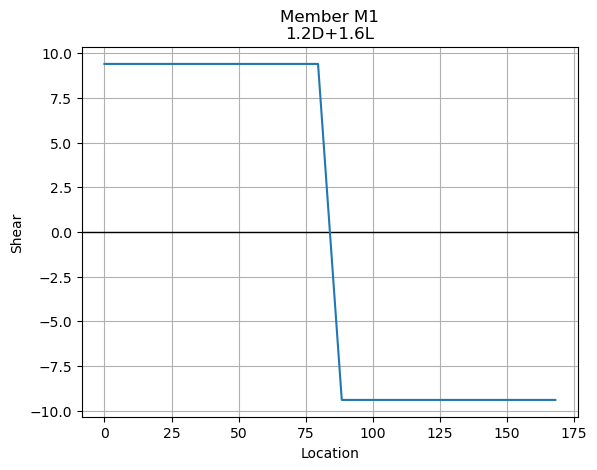

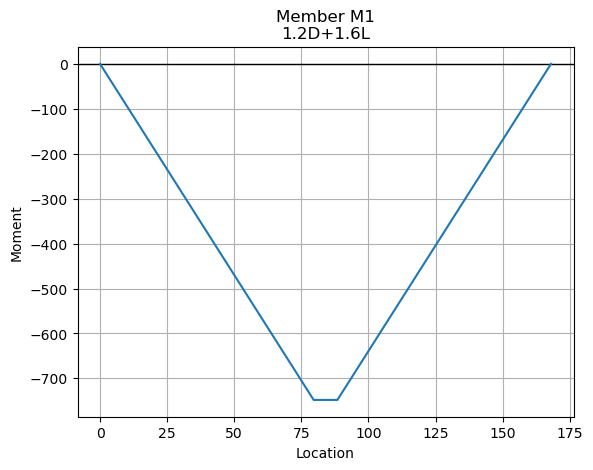

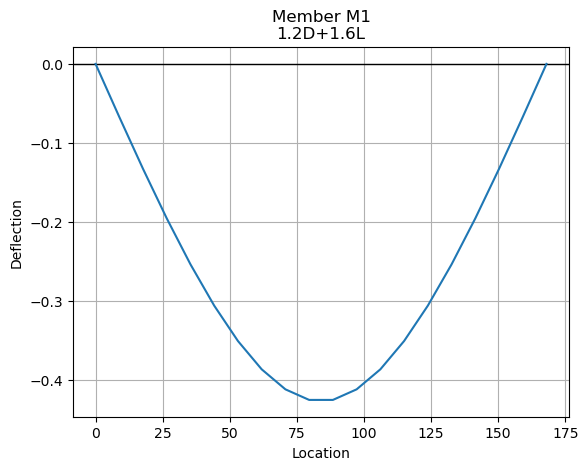

Left Support Reaction: 9.400000000000002 kip
Right Support Reacton: 9.399999999999999 kip


In [25]:
# Example of a simply supported beam with a point load.
# Units used for the model in this example are inches and kips

from Pynite.FEModel3D import FEModel3D
from Pynite import Visualization

simple_beam = FEModel3D()

# Add nodes (14 ft apart)
simple_beam.add_node('N1', 0, 0, 0)
simple_beam.add_node('N2', 14*12, 0, 0)

# Define a material
E = 29000       # Modulus of elasticity (ksi)
G = 11200       # Shear modulus (ksi)
nu = 0.3        # Poisson's ratio
rho = 2.836e-4  # Density (kci)
simple_beam.add_material('Steel', E, G, nu, rho)

# Add a section
simple_beam.add_section('MySection', 20, 100, 150, 250)
simple_beam.add_member('M1', 'N1', 'N2', 'Steel', 'MySection')

# Provide simple supports
simple_beam.def_support('N1', True, True, True, True, False, False)
simple_beam.def_support('N2', True, True, True, True, False, False)

# Add loads and combinations
simple_beam.add_member_pt_load('M1', 'Fy', -5, 7*12, 'D')
simple_beam.add_member_pt_load('M1', 'Fy', -8, 7*12, 'L')
simple_beam.add_load_combo('1.4D', {'D':1.4})
simple_beam.add_load_combo('1.2D+1.6L', {'D':1.2, 'L':1.6})

simple_beam.analyze(check_statics=True)

from Pynite.Visualization import Renderer
renderer = Renderer(simple_beam)
renderer.annotation_size = 10
renderer.deformed_shape = True
renderer.deformed_scale = 30
renderer.render_loads = True
renderer.combo_name = '1.2D+1.6L'
renderer.render_model()

# Print the shear, moment, and deflection diagrams
simple_beam.members['M1'].plot_shear('Fy', '1.2D+1.6L')
simple_beam.members['M1'].plot_moment('Mz', '1.2D+1.6L')
simple_beam.members['M1'].plot_deflection('dy', '1.2D+1.6L')

print('Left Support Reaction:', simple_beam.nodes['N1'].RxnFY['1.2D+1.6L'], 'kip')
print('Right Support Reacton:', simple_beam.nodes['N2'].RxnFY['1.2D+1.6L'], 'kip')
